# Microgrid sizing optimization: compare algo record learning curves

Notebook extended from the **Microgrid sizing optimization** notebook example in `../Microgrids.jl/examples/`.

PH, sept 2023

In [197]:
using Microgrids
using NLopt # optimization solvers
using Printf # pretty print results
using Random, Statistics
using CSV, DataFrames
using PyPlot

## Load Microgrid project data

Loading parameters and time series for a Microgrid project with *wind* and *solar* sources, plus a *battery* and a *dispatchable generator*. 
Values gathered from the Microgrid_Wind-Solar.ipynb example notebook.

In [2]:
include("../Microgrids.jl/examples/Microgrid_Wind-Solar_data.jl");

Data definition for Microgrid with wind, solar, storage and generator...


## Setting up the cost function (criterion) to be optimized


In [3]:
"""Simulate the performance of a Microgrid project of size `x`
with x=[power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind]

Returns stats, costs
"""
    function simulate_microgrid(x)
    project = Project(lifetime, discount_rate, timestep, "€")
    # Split decision variables (converted MW → kW):
    power_rated_gen = x[1]*1000
    energy_rated_sto = x[2]*1000
    power_rated_pv = x[3]*1000
    power_rated_wind = x[4]*1000

    # Create components
    gen = DispatchableGenerator(power_rated_gen,
        fuel_intercept, fuel_slope, fuel_price,
        investment_price_gen, om_price_gen, lifetime_gen,
        load_ratio_min,
        replacement_price_ratio, salvage_price_ratio, fuel_unit)
    batt = Battery(energy_rated_sto,
        investment_price_sto, om_price_sto, lifetime_sto, lifetime_cycles,
        charge_rate, discharge_rate, loss_factor_sto, SoC_min, SoC_ini,
        replacement_price_ratio, salvage_price_ratio)
    pv = Photovoltaic(power_rated_pv, irradiance,
        investment_price_pv, om_price_pv,
        lifetime_pv, derating_factor_pv,
        replacement_price_ratio, salvage_price_ratio)
    windgen = WindPower(power_rated_wind, cf_wind,
        investment_price_wind, om_price_wind,
        lifetime_wind,
        replacement_price_ratio, salvage_price_ratio)
    mg = Microgrid(project, Pload, gen, batt, [pv, windgen])

    # Launch simulation:
    traj, stats, costs = simulate(mg)

    return stats, costs
end

simulate_microgrid

In [4]:
"Multi-objective criterion for microgrid performance: lcoe, shedding rate"
function obj_multi(x)
    stats, costs = simulate_microgrid(x)
    # Extract KPIs of interest
    lcoe = costs.lcoe # $/kWh
    shed_rate = stats.shed_rate; # in [0,1]
    return lcoe, shed_rate
end

obj_multi

In [5]:
"""Mono-objective criterion: LCOE + penalty if shedding rate > `shed_max`

with signature adapted to NLopt with `grad` as 2nd argument

load shedding penalty threshold `shed_max` should be in  [0,1[
"""
function obj(x, grad, shed_max, w_shed_max=1e5)
    lcoe, shed_rate = obj_multi(x)
    over_shed = shed_rate - shed_max
    if over_shed > 0.0
        penalty = w_shed_max*over_shed
    else
        penalty = 0.0
    end
    J = lcoe + penalty
end

obj

### Tests the objective functions

Test of the simulator wrapper (on a baseline sizing):

In [6]:
# Baseline sizing: same as in Microgrid_Wind-Solar.ipynb notebook
x_base = [power_rated_gen, energy_rated_sto, power_rated_pv, power_rated_wind]/1000.
# run simulation:
stats, costs = simulate_microgrid(x_base)
x_base, costs.lcoe, costs.npc/1e6

([1.8, 5.0, 3.0, 0.9], 0.22924812869928668, 21.89002772908652)

In [7]:
# Test:
shed_max = 0.01 # in [0,1]

println("Base. multi: ", obj_multi(x_base), " mono: ", obj(x_base,[], shed_max))

Base. multi: (0.22924812869928668, 0.0) mono: 0.22924812869928668


## Optimization

### Setting up the optimization problem

bounds of the design space and starting point: derived from maximal load power

In [8]:
Pload_max = maximum(Pload)

xmin = [0., 0., 1e-3, 0.] # 1e-3 instead of 0.0, because LCOE is NaN if ther is exactly zero generation
xmax = [1.2, 10.0, 10.0, 5.0] * (Pload_max/1000)

4-element Vector{Float64}:
  2.0484
 17.07
 17.07
  8.535

Optionally ban some choices:

In [9]:
# Solar power forbidden (optional)
#xmax[3] = 1e-3
# Wind power forbidden (optional)
#xmax[4] = 0.

Check cost function on `xmin` and `xmax`

In [10]:
obj_multi(xmin), obj_multi(xmax)

((0.10149685980963595, 0.9998470957371233), (0.8229416738277807, 0.0))

### Initial point generation from Random

In [11]:
"""uniformly random vector between xmin and xmax, for a given PRNG seed"""
function x0_rng(seed, xmin, xmax)
    n = length(xmin)
    rng = MersenneTwister(seed)
    xmin + rand(rng, n).*(xmax-xmin)
end
# Test with 3 different seeds:
[x0_rng(0, xmin, xmax) x0_rng(0, xmin, xmax) x0_rng(1, xmin, xmax) x0_rng(2, xmin, xmax)]

4×4 Matrix{Float64}:
  1.68716   1.68716  0.483491   0.751346
 15.5398   15.5398   5.91505    8.94261
  2.80997   2.80997  5.3386     3.58987
  1.5135    1.5135   0.0675057  6.99305

### Wrapper of the optimization process

This is an optional step, but recommended to explore easily the impact of the many parameters taken by optimization algorithms.

See [optimization termination conditions](https://nlopt.readthedocs.io/en/latest/NLopt_Introduction/#termination-conditions) in NLopt documention for the meaning of `xtol_rel`

In [12]:
"""Optimize sizing of microgrid based on the `obj` function

Parameters:
- `x0`: initial sizing (for the algorithms which need them)
- `shed_max`: load shedding penalty threshold (same as in `obj`)
- `algo` could be one of LN_SBPLX, GN_DIRECT, GN_ESCH...
- `maxeval`: maximum allowed number of calls to the objective function,
  that is to the microgrid simulation
- `xtol_rel`: termination condition based on relative change of sizing, see NLopt doc.
- `srand`: random number generation seed (for algorithms which use some stochastic search)

Problem bounds are taken as the global variables `xmin`, `xmax`,
but could be added to the parameters as well.
"""
function optim_mg(x0, shed_max, algo=:LN_SBPLX, maxeval=1000, xtol_rel=1e-4, srand=1)
    nx = length(x0) # number of optim variables
    opt = Opt(algo, nx)
    NLopt.srand(srand)
    
    opt.lower_bounds = xmin
    opt.upper_bounds = xmax
    opt.min_objective = (x, grad) -> obj(x, grad, shed_max)
    opt.xtol_rel = xtol_rel
    opt.maxeval = maxeval
    
    (fopt, xopt, ret) = optimize(opt, x0)
    return fopt, xopt, ret, opt.numevals
end

optim_mg

In [279]:
"""a heuristic/manual global optimization of mg

param: shed_max
maxeval: should be large ~10^4
"""
function global_optim_mg(shed_max, maxeval)
    srand=1
    x0 = xmax/2
    xtol_rel=1e-4
    # Two global optimizers
    fopt_crs, xopt_crs, ret_crs, numevals_crs = optim_mg(x0, shed_max, :GN_CRS2_LM, maxeval, xtol_rel, srand)
    fopt_dir, xopt_dir, ret_dir, numevals_dir = optim_mg(x0, shed_max, :GN_DIRECT, maxeval, xtol_rel, srand)
    # polishing with SBPLX
    fopt_crs2, xopt_crs2, ret_crs2, numevals_crs2 = optim_mg(xopt_crs, shed_max, :LN_SBPLX, maxeval, xtol_rel, srand)
    fopt_dir2, xopt_dir2, ret_dir2, numevals_dir2 = optim_mg(xopt_dir, shed_max, :LN_SBPLX, maxeval, xtol_rel, srand)
    fopt_list = [fopt_crs, fopt_crs2, fopt_dir, fopt_dir2]
    i_min = argmin(fopt_list)
    if i_min<=2
        algo=:GN_CRS2_LM
    else
        algo=:GN_DIRECT
    end
    if i_min%2 == 0
        polish=true
    else
        polish=false
    end
    println("Best optimum found with $algo" * (polish ? " (with local polishing)" : ""))
    return fopt_list[i_min]
end

# short test
global_optim_mg(0.01, 1000)

Best optimum found with GN_CRS2_LM (with local polishing)


0.19062915852129575

### Run optimization & analyze results

#### Experiment design (DOE/DOX): parameters

with the settings below:
- it makes for 3360 cases
- it takes 930 s to run (cases with high maxeval are dominant)

Optimization algorithms to be compared:
- all NLopt's [global algorithms](https://nlopt.readthedocs.io/en/latest/NLopt_Algorithms/#global-optimization),
  - except StoGO because needs gradient
- local: Subplex & NelderMead. 

In [276]:
algo_list = [:GN_DIRECT, :GN_CRS2_LM, :GN_AGS, :GN_ISRES, :GN_ESCH, :LN_SBPLX, :LN_NELDERMEAD];

Random seeds (also used for initial point `x0`)

In [ ]:
nrand = 10
srand_list = collect(1:nrand)

Log-spaced sweep on `maxeval`:

In [121]:
n = 6 # attemp to find round values which are approximately log-spaced on 10-100:
print(round.([10^(i/n) for i in 0:n-1]*10))

[10.0, 15.0, 22.0, 32.0, 46.0, 68.0]

In [283]:
#maxeval_list = [10, 20, 30, 60] # close to 10^(1/4) ~ 1.8 increments
maxeval_list = [10, 15, 20, 30, 50, 70] # close to 10^(1/6) ~ 1.5
maxeval_list = [maxeval_list; maxeval_list*10; maxeval_list*100; 10000] # expand to 10k
maxeval_list = maxeval_list[4:end] # remove 10, 15, 20 iterations
println("maxeval: ", maxeval_list)

maxeval: [30, 50, 70, 100, 150, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 5000, 7000, 10000]


A few values of `shed_max` to avoid concluding on a too specific casem

In [ ]:
shed_max_list = [0., 0.001, 0.01]

In [281]:
n_exp = length(algo_list)*length(srand_list)*length(maxeval_list)*length(shed_max_list)
println("Number of optimization cases: $n_exp")

Number of optimization cases: 3360


##### Tiny experiment design variant

for testing the code below

In [284]:
#algo_list = [:GN_CRS2_LM, :LN_SBPLX]
#srand_list = collect(1:2)
#maxeval_list = [30, 1000]
#shed_max_list = [0., 0.01]

#### Expermiment setup

Initial starting points for each seed `srand`:

In [146]:
[x0_rng(srand, xmin, xmax) for srand in srand_list]

10-element Vector{Vector{Float64}}:
 [0.4834907052541369, 5.915045432256765, 5.338595242528336, 0.06750573373843591]
 [0.751345771241941, 8.942607271569909, 3.589867014821392, 6.993050986142526]
 [1.6626830127935228, 16.87254047910793, 13.78630141409919, 8.279725362491114]
 [1.393074306890772, 14.926637765423816, 15.773952313776764, 7.931884627830944]
 [1.0863989706781596, 13.263546529065476, 5.144066424643939, 7.522314745748859]
 [1.0477103816579312, 2.071848007538482, 14.174680658430868, 0.22525509869180715]
 [1.6641991917800218, 11.180465321297689, 8.35821078915733, 0.6722126360803466]
 [0.025313521763687143, 15.265474353001931, 15.03624342115576, 6.565571713985442]
 [1.4483795394919572, 4.5291913117705995, 4.40858158194036, 1.877258176474318]
 [0.2306138799006112, 6.287121116534988, 5.880485720913604, 0.4834688829938778]

### Running the experiment

[constructing a DataFrame Row by Row](https://dataframes.juliadata.org/stable/man/getting_started/#Constructing-Row-by-Row)

In [153]:
# Empty DataFrame
df = DataFrame(
    shed_max=Float64[], algo=String[], srand=Int[], maxeval=Int[],
    numevals=Int[], ret=String[], topt=Float64[],
    fopt=Float64[], Δfopt_rel=Float64[], lcoe_opt=Float64[], shed_rate_opt=Float64[],
    xopt_gen=Float64[], xopt_sto=Float64[], xopt_pv=Float64[], xopt_wind=Float64[]
)

Row,shed_max,algo,srand,maxeval,numevals,ret,topt,fopt,Δfopt_rel,lcoe_opt,shed_rate_opt,xopt_gen,xopt_sto,xopt_pv,xopt_wind
,Float64,String,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64


In [154]:
t_exp = @elapsed for shed_max in shed_max_list # problem type
    @printf("shed_max: %.3f\n", shed_max)
    for maxeval in maxeval_list, algo in algo_list, srand in srand_list # optimizer settings
        x0 = x0_rng(srand, xmin, xmax)
        @printf("maxeval=%d, algo: %s, srand=%d: ", maxeval, algo, srand)
        topt = @elapsed fopt, xopt, ret, numevals = optim_mg(x0, shed_max, algo, maxeval, xtol_rel, srand)
        @printf("%.6f in %.1f s\n", fopt, topt)
        # compute multiobjective performance
        lcoe_opt, shed_rate_opt = obj_multi(xopt)
        # difference to global optimum: done in post-processing, because precomputed LUT1 is not "optimal" enough
        Δfopt_rel_ = NaN
        # convert and round sizing to 1/100th of kW
        xopt = round.(xopt*1000; digits=2) # kW  
        push!(df, (
                shed_max, String(algo), srand, maxeval,
                numevals, String(ret), topt,
                fopt, Δfopt_rel_, lcoe_opt, shed_rate_opt,
                xopt[1], xopt[2], xopt[3], xopt[4]     
        ))
    end
end
@printf("Experiment run in %.1f s\n", t_exp)

shed_max: 0.000
maxeval=30, algo: GN_DIRECT, srand=1: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=2: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=3: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=4: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=5: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=6: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=7: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=8: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=9: 0.213092 in 0.0 s
maxeval=30, algo: GN_DIRECT, srand=10: 0.213092 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=1: 0.375415 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=2: 0.301559 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=3: 0.264891 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=4: 0.324644 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=5: 0.239529 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=6: 0.308757 in 0.0 s
maxeval=30, algo: GN_CRS2_LM, srand=7: 0.278757 in 0.0 s
maxeval=30, algo: GN_CRS

Display data:

In [156]:
df

Row,shed_max,algo,srand,maxeval,numevals,ret,topt,fopt,Δfopt_rel,lcoe_opt,shed_rate_opt,xopt_gen,xopt_sto,xopt_pv,xopt_wind
,Float64,String,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,GN_DIRECT,1,30,30,MAXEVAL_REACHED,0.00627826,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
2,0.0,GN_DIRECT,2,30,30,MAXEVAL_REACHED,0.00956175,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
3,0.0,GN_DIRECT,3,30,30,MAXEVAL_REACHED,0.00644736,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
4,0.0,GN_DIRECT,4,30,30,MAXEVAL_REACHED,0.00907751,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
5,0.0,GN_DIRECT,5,30,30,MAXEVAL_REACHED,0.00639622,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
6,0.0,GN_DIRECT,6,30,30,MAXEVAL_REACHED,0.00759706,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
7,0.0,GN_DIRECT,7,30,30,MAXEVAL_REACHED,0.00705381,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
8,0.0,GN_DIRECT,8,30,30,MAXEVAL_REACHED,0.00624483,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
9,0.0,GN_DIRECT,9,30,30,MAXEVAL_REACHED,0.00692046,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5


### Post-process experiment data: compute relative difference of optimum to global optimum

#### Compute table of global optima

Look up table (LUT) 1: global optimum for each `shed_max` in `shed_max_list`, from a heuristic global search. Useful if dataset is small (with small largest value of maxeval).

However, this LUT alone is not reliable enough, because due to random seed, some optim cases in the experiment can fall below these value *even with smaller values of `maxeval`*!

In [147]:
maxeval = 30000  # about 6 s/iter
fopt_global_shedmax1 = zero(shed_max_list)
for i in eachindex(shed_max_list)
    shed_max = shed_max_list[i]
    fopt_global_shedmax1[i] = global_optim_mg(shed_max, maxeval)
end
fopt_global_shedmax1

Best optimum found with GN_CRS2_LM (with local polishing)
Best optimum found with GN_CRS2_LM (with local polishing)
Best optimum found with GN_DIRECT (with local polishing)


3-element Vector{Float64}:
 0.2073398227713372
 0.20073396732210874
 0.19062974133516375

LUT 2: best optima **in dataset**, for each `shed_max`

In [162]:
df_gshed = groupby(df, :shed_max); # GroupedDataFrame with 3 groups based on key: shed_max
fopt_global_shedmax2 = combine(df_gshed, :fopt => minimum).fopt_minimum

3-element Vector{Float64}:
 0.20734697075110287
 0.20073379506526953
 0.19062712560685377

Compare to LUT2 to LUT1:
- for shedmax = 0.0, the first global search was the best
- for shedmax = 0.001 and shedmax = 0.01, the best global optima were found during the experiment

In [164]:
fopt_global_shedmax2 ./ fopt_global_shedmax1

3-element Vector{Float64}:
 1.0000344747076086
 0.9999991418650191
 0.9999862784878599

Update LUT:

In [166]:
fopt_global_shedmax = min.(fopt_global_shedmax1, fopt_global_shedmax2)

3-element Vector{Float64}:
 0.2073398227713372
 0.20073379506526953
 0.19062712560685377

#### Compute relative difference to global optima

In [300]:
"""log10 relative difference of cost `fopt` to the global optimum
(for a given `shed_max`)

log10((`fopt`-f*)/f*)

where f* is found in the `fopt_global_shedmax` look up table

optionally, log values below `Δf_satlow` can be saturated at `Δf_satlow`
(-Inf by default, i.e. no saturation)
"""
function Δfopt_rel(fopt, shed_max; Δf_satlow=-Inf)
    i_shed = findfirst(shed_max_list .== shed_max)
    fopt_best = fopt_global_shedmax[i_shed]
    if fopt < fopt_best
        println("WARNING: `fopt` < f* from LUT")
        return NaN
    end
    Δfrel = log10((fopt - fopt_best) / fopt_best)
    Δfrel < Δf_satlow ? Δf_satlow : Δfrel
end

# Tests:
Δfopt_rel(0.22, 0.0), # regular case
Δfopt_rel(0.20734, 0.0), # very close to global optim
Δfopt_rel(0.20734, 0.0; Δf_satlow=-5.),  # very close to global optim → saturate
Δfopt_rel(0.10, 0.0) # below global optim → WARNING + NaN

(-1.2142429376034183, -6.068148762255366, -5.0, NaN)

Update `Δfopt_rel` column in dataset, **with saturation at -15.**

In [301]:
for row in eachrow(df)
    row.Δfopt_rel = Δfopt_rel(row.fopt, row.shed_max; Δf_satlow=-15.)
end

Display final dataset:

In [302]:
df

Row,shed_max,algo,srand,maxeval,numevals,ret,topt,fopt,Δfopt_rel,lcoe_opt,shed_rate_opt,xopt_gen,xopt_sto,xopt_pv,xopt_wind
,Float64,String,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,GN_DIRECT,1,30,30,MAXEVAL_REACHED,0.00627826,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
2,0.0,GN_DIRECT,2,30,30,MAXEVAL_REACHED,0.00956175,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
3,0.0,GN_DIRECT,3,30,30,MAXEVAL_REACHED,0.00644736,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
4,0.0,GN_DIRECT,4,30,30,MAXEVAL_REACHED,0.00907751,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
5,0.0,GN_DIRECT,5,30,30,MAXEVAL_REACHED,0.00639622,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
6,0.0,GN_DIRECT,6,30,30,MAXEVAL_REACHED,0.00759706,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
7,0.0,GN_DIRECT,7,30,30,MAXEVAL_REACHED,0.00705381,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
8,0.0,GN_DIRECT,8,30,30,MAXEVAL_REACHED,0.00624483,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
9,0.0,GN_DIRECT,9,30,30,MAXEVAL_REACHED,0.00692046,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5


## Export

In [303]:
n_exp = size(df)[1]

3360

In [304]:
CSV.write("df_$n_exp.csv", df)

"df_3360.csv"

### read back

In [305]:
# read "df_$n_exp.csv" with n_exp = 3360

## Analysis and plot

### Stats: min/mean/max of Δfopt_rel, numevals across srand

for each :shed_max, :algo, :maxeval

Group by all params except `srand`

In [306]:
df_gsrand = groupby(df, [:shed_max, :algo, :maxeval])

Row,shed_max,algo,srand,maxeval,numevals,ret,topt,fopt,Δfopt_rel,lcoe_opt,shed_rate_opt,xopt_gen,xopt_sto,xopt_pv,xopt_wind
,Float64,String,Int64,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.0,GN_DIRECT,1,30,30,MAXEVAL_REACHED,0.00627826,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
2,0.0,GN_DIRECT,2,30,30,MAXEVAL_REACHED,0.00956175,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
3,0.0,GN_DIRECT,3,30,30,MAXEVAL_REACHED,0.00644736,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
4,0.0,GN_DIRECT,4,30,30,MAXEVAL_REACHED,0.00907751,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
5,0.0,GN_DIRECT,5,30,30,MAXEVAL_REACHED,0.00639622,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
6,0.0,GN_DIRECT,6,30,30,MAXEVAL_REACHED,0.00759706,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
7,0.0,GN_DIRECT,7,30,30,MAXEVAL_REACHED,0.00705381,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
8,0.0,GN_DIRECT,8,30,30,MAXEVAL_REACHED,0.00624483,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5
9,0.0,GN_DIRECT,9,30,30,MAXEVAL_REACHED,0.00692046,0.213092,-1.55684,0.213092,0.0,1707.0,4741.67,2845.83,1422.5


Compute min/mean/max on groups:
- special treatment for mean of Δfopt_rel: use instead Δfopt_rel(mean(fopt)) (otherwise, -Inf "wins" the mean)

In [307]:
df_stats = combine(df_gsrand,
    :Δfopt_rel => minimum,
    [:fopt, :shed_max] => ((fopt, shed_max) -> Δfopt_rel(mean(fopt), shed_max[1])) => :Δfopt_rel_mean,
    #:Δfopt_rel => mean,
    :Δfopt_rel => maximum,
    :numevals => minimum, :numevals => mean, :numevals => maximum)

Row,shed_max,algo,maxeval,Δfopt_rel_minimum,Δfopt_rel_mean,Δfopt_rel_maximum,numevals_minimum,numevals_mean,numevals_maximum
,Float64,String,Int64,Float64,Float64,Float64,Int64,Float64,Int64
1,0.0,GN_DIRECT,30,-1.55684,-1.55684,-1.55684,30,30.0,30
2,0.0,GN_CRS2_LM,30,-0.808979,-0.377451,-0.0911796,30,30.0,30
3,0.0,GN_AGS,30,-0.75227,-0.75227,-0.75227,30,30.0,30
4,0.0,GN_ISRES,30,-0.808979,-0.384446,-0.128648,30,30.0,30
5,0.0,GN_ESCH,30,-0.78189,0.75985,1.63277,30,30.0,30
6,0.0,LN_SBPLX,30,-1.57436,2.18935,3.18761,30,30.0,30
7,0.0,LN_NELDERMEAD,30,-1.54371,-0.108898,0.44683,30,30.0,30
8,0.0,GN_DIRECT,50,-1.71365,-1.71365,-1.71365,50,50.0,50
9,0.0,GN_CRS2_LM,50,-0.99534,-0.485236,-0.128648,50,50.0,50


### Plot

In [317]:
df_algo = df_stats[
    (df_stats.shed_max .== 0.01) .& (df_stats.algo .== "GN_DIRECT"),
    :]

Row,shed_max,algo,maxeval,Δfopt_rel_minimum,Δfopt_rel_mean,Δfopt_rel_maximum,numevals_minimum,numevals_mean,numevals_maximum
,Float64,String,Int64,Float64,Float64,Float64,Int64,Float64,Int64
1,0.01,GN_DIRECT,30,-1.24682,-1.24682,-1.24682,30,30.0,30
2,0.01,GN_DIRECT,50,-1.61178,-1.61178,-1.61178,50,50.0,50
3,0.01,GN_DIRECT,70,-1.61178,-1.61178,-1.61178,70,70.0,70
4,0.01,GN_DIRECT,100,-1.66868,-1.66868,-1.66868,100,100.0,100
5,0.01,GN_DIRECT,150,-1.81357,-1.81357,-1.81357,150,150.0,150
6,0.01,GN_DIRECT,200,-1.97724,-1.97724,-1.97724,200,200.0,200
7,0.01,GN_DIRECT,300,-2.14317,-2.14317,-2.14317,300,300.0,300
8,0.01,GN_DIRECT,500,-2.41215,-2.41215,-2.41215,500,500.0,500
9,0.01,GN_DIRECT,700,-2.44959,-2.44959,-2.44959,700,700.0,700


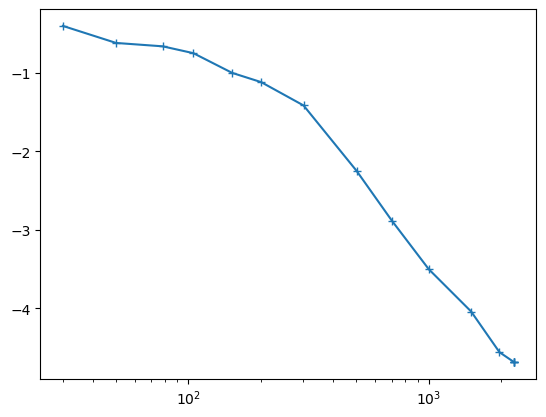

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f32140204f0>

In [316]:
plt.semilogx(df_algo.numevals_mean, df_algo.Δfopt_rel_mean, "+-")

In [310]:
nrand == 10

true

In [311]:
nrand = 10

10

Select a subset of algo:
- :GN_AGS: not promising (stagnation)
- :GN_ESCH: a bit like :GN_ISRES (ISRES wins <100 and >6000 while ESCH can be better by 0.5 (in log10, i.e. a factor 3) in between)
- :LN_NELDERMEAD: like :LN_SBPLX but halts earlier

In [410]:
algo_list_select = [:GN_CRS2_LM, :GN_DIRECT, :GN_ISRES, :LN_SBPLX]
#algo_list_select = algo_list; # all
println("n algo compared: ", length(algo_list_select))

n algo compared: 4


#### Overview of all `shed_max`: mean and best perf

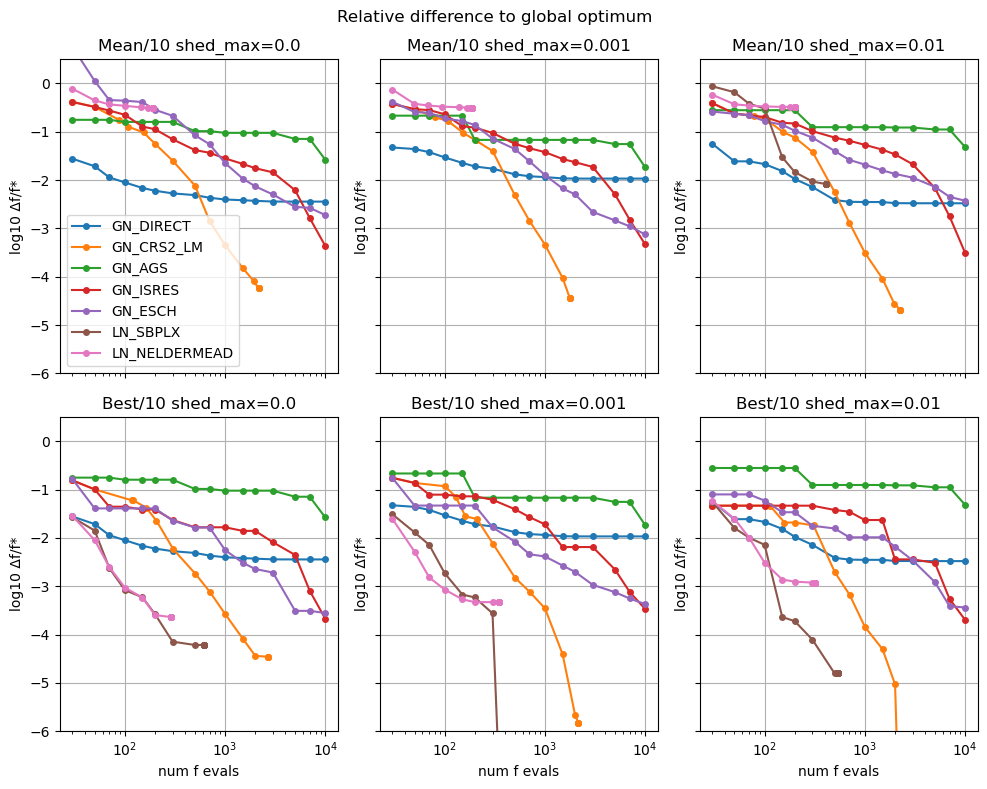

In [409]:
fig, ax = plt.subplots(2,3, figsize=(10,8), sharex=true, sharey=true)

for (j, shed_max) in enumerate(shed_max_list)
    for (i, algo) in enumerate(algo_list_select)
        c = "C$(i-1)" # color
        df_algo = df_stats[
            (df_stats.shed_max .== shed_max) .& (df_stats.algo .== String(algo)),
            :]
        ax[1,j].plot(df_algo.numevals_mean, df_algo.Δfopt_rel_mean, label=algo,
                     "o-", color=c, ms=4)
        ax[2,j].plot(df_algo.numevals_maximum, df_algo.Δfopt_rel_minimum, label=algo,
                     "o-", color=c, ms=4)
    end
    ax[1,j].set(
        title="Mean/$nrand shed_max=$shed_max",
        ylabel="log10 Δf/f*",
        xscale="log"
    )
    ax[2,j].set(
        title="Best/$nrand shed_max=$shed_max",
        ylabel="log10 Δf/f*",
        xlabel="num f evals",
        xscale="log"
    )
    ax[1,j].grid(true)
    ax[2,j].grid(true)
end
ax[1,1].legend()

ax[1,1].set_ylim(-6, 0.5)

fig.suptitle("Relative difference to global optimum")

fig.tight_layout()

fig.savefig("opti_budget_multi.png", dpi=250)

See docs:
- https://github.com/JuliaPy/PyPlot.jl#modifying-matplotlibrcparams
- https://matplotlib.org/stable/gallery/text_labels_and_annotations/font_family_rc.html
- https://matplotlib.org/stable/users/explain/text/fonts.html#fonts-in-svg

In [471]:
plt.rcdefaults()
rcParams = PyPlot.PyDict(plt."rcParams")
rcParams["font.family"] = ["serif"]
rcParams["font.serif"] = ["Linux Libertine O"]
rcParams["svg.fonttype"] = "none"
plt.rcdefaults()

figure saved as opti_budget_variability_shedmax_0.001.png


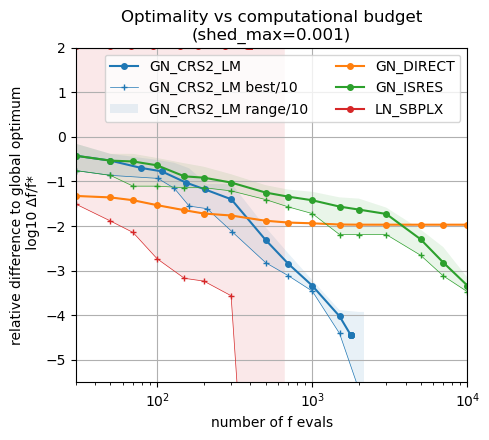

In [472]:
shed_max = 0.001

fig, ax = plt.subplots(figsize=(5,4.5)) # size (4.5,4) used for SVG
for (i, algo) in enumerate(algo_list_select)
    c = "C$(i-1)" # color
    df_algo = df_stats[
        (df_stats.shed_max .== shed_max) .& (df_stats.algo .== String(algo)),
        :]
    ax.plot(df_algo.numevals_mean, df_algo.Δfopt_rel_mean, label=algo,
            "o-", color=c, ms=4)
    #ax.plot(df_algo.numevals_maximum, df_algo.Δfopt_rel_maximum, label = i==1 ? String(algo) * " worse" : "",
    #        ":", color=c)
    ax.plot(df_algo.numevals_maximum, df_algo.Δfopt_rel_minimum,
            label = i==1 ? String(algo) * " best/$nrand" : "",
            "+-", color=c, ms=4, alpha=1, lw=0.5)
    ax.fill_between(df_algo.numevals_maximum, df_algo.Δfopt_rel_minimum, df_algo.Δfopt_rel_maximum,
                    label = i==1 ? String(algo) * " range/$nrand" : "",
                    alpha=0.1, lw=0, zorder=-10 # fills should be below plain curves
    )
end

ax.set(
    title="Optimality vs computational budget\n(shed_max=$shed_max)", # Relative  optimum
    ylabel="relative difference to global optimum\n log10 Δf/f*",
    xlabel="number of f evals",
    xscale="log",
    xlim=(30, 10^4),
    ylim=(-5.5,2)
)
ax.grid(true)
ax.legend(ncols=2)
fig.tight_layout()
figname = @sprintf("opti_budget_variability_shedmax_%.3f.png", shed_max)
println("figure saved as ", figname)
fig.savefig(figname, dpi=250)

#### Actual number of f evals vs maxeval

most algo have numevals == maxeval, but:
- local searches stop earlier
- CRS2 also stops earlier, but only above 2k points
- oddly enough, CRS2 stops slighly above maxeval (by a factor 2 max)

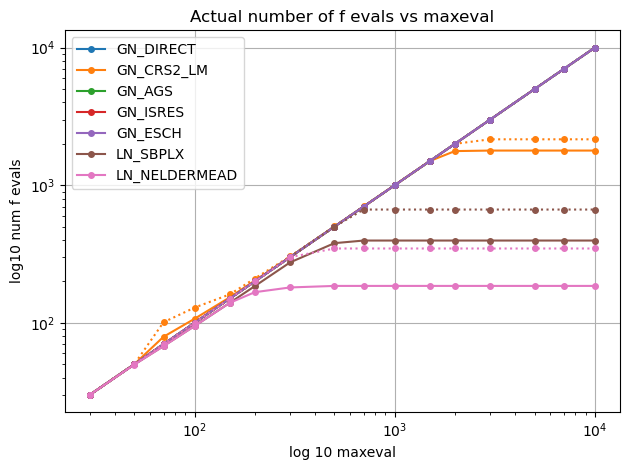

In [319]:
shed_max = 0.001

fig, ax = plt.subplots()
for (i, algo) in enumerate(algo_list)
    c = "C$(i-1)" # color
    df_algo = df_stats[
        (df_stats.shed_max .== shed_max) .& (df_stats.algo .== String(algo)),
        :]
    ax.plot(df_algo.maxeval, df_algo.numevals_mean, label=algo,
            "o-", color=c, ms=4)
    ax.plot(df_algo.maxeval, df_algo.numevals_maximum,
            "o:", color=c, ms=4)
end

ax.set(
    title="Actual number of f evals vs maxeval",
    ylabel="log10 num f evals",
    xlabel="log 10 maxeval",
    xscale="log",
    yscale="log"
)
ax.grid(true)
ax.legend()
fig.tight_layout()